## EfficientNet - with parameter comparisons

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

### Define training process

In [7]:
def trainingEfficientNet(model, tr_loader, va_loader,learning_rate, num_epoch=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    # Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "valid_loss": [], "valid_accuracy": [], 
               "valid_f1":[], "valid_precision":[], "valid_recall":[], "total_duration":0}
    total_duration = 0

    # Training and Validation Loop with Progress Updates
    epochs = num_epoch
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        # Use tqdm for batch-level progress
        for images, labels in tqdm(tr_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(tr_loader)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
        
        # Validation Phase
        model.eval()
        valid_loss = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            # Use tqdm for validation progress
            for images, labels in tqdm(va_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(va_loader)
        valid_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        epoch_duration = time.time() - start_time
        total_duration += epoch_duration

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["valid_accuracy"].append(valid_accuracy)
        history["valid_f1"].append(valid_f1)
        history["valid_precision"].append(valid_precision)
        history["valid_recall"].append(valid_recall)

        # Print the progress with more metrics and time per epoch
        print(f"Epoch {epoch+1}/{epochs} - Duration: {epoch_duration:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1 Score: {valid_f1:.4f}, Valid Precision: {valid_precision:.4f}, Valid Recall: {valid_recall:.4f}")

    return model, history

### Define training Dataloader

In [8]:
def loadTrainingData(i_size, b_size, original=True):
    # Data transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Datasets
    train_dataset = datasets.ImageFolder("archive/train", transform=train_transforms)
    valid_dataset = datasets.ImageFolder("archive/valid", transform=valid_test_transforms)
    test_dataset = datasets.ImageFolder("archive/test", transform=valid_test_transforms)

    # DataLoaders
    batch_size = b_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if(original == False):
        train_original = datasets.ImageFolder("archive/train", transform=valid_test_transforms) # original training set
        augmented_dataset = datasets.ImageFolder("archive/train", transform=train_transforms) # trainsformed training set
        train_combined = ConcatDataset([train_original, augmented_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(valid_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [9]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set CUDA seed (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # for all GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Sub-model 1:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, original training set

In [10]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)  # Use EfficientNet-B0
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust for num_classes
model_1, history_1 = trainingEfficientNet(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Duration: 54.38s
Train Loss: 2.0068, Train Precision: 0.5185, Train Recall: 0.5074
Valid Loss: 0.6823, Valid Accuracy: 0.7880, Valid F1 Score: 0.7835, Valid Precision: 0.8219, Valid Recall: 0.7880


Epoch 2/10 - Duration: 45.43s
Train Loss: 0.7843, Train Precision: 0.7760, Train Recall: 0.7754
Valid Loss: 0.4522, Valid Accuracy: 0.8740, Valid F1 Score: 0.8684, Valid Precision: 0.8852, Valid Recall: 0.8740


Epoch 3/10 - Duration: 47.91s
Train Loss: 0.5658, Train Precision: 0.8347, Train Recall: 0.8344
Valid Loss: 0.4491, Valid Accuracy: 0.8780, Valid F1 Score: 0.8697, Valid Precision: 0.9040, Valid Recall: 0.8780


Epoch 4/10 - Duration: 46.47s
Train Loss: 0.4651, Train Precision: 0.8593, Train Recall: 0.8590
Valid Loss: 0.5029, Valid Accuracy: 0.8740, Valid F1 Score: 0.8646, Valid Precision: 0.9008, Valid Recall: 0.8740


Epoch 5/10 - Duration: 44.97s
Train Loss: 0.3936, Train Precision: 0.8819, Train Recall: 0.8811
Valid Loss: 0.3161, Valid Accuracy: 0.9140, Valid F1 Score: 0.9095, Valid Precision: 0.9280, Valid Recall: 0.9140


Epoch 6/10 - Duration: 45.16s
Train Loss: 0.3574, Train Precision: 0.8882, Train Recall: 0.8877
Valid Loss: 0.3794, Valid Accuracy: 0.9200, Valid F1 Score: 0.9175, Valid Precision: 0.9343, Valid Recall: 0.9200


Epoch 7/10 - Duration: 45.09s
Train Loss: 0.3319, Train Precision: 0.8961, Train Recall: 0.8957
Valid Loss: 0.3004, Valid Accuracy: 0.9340, Valid F1 Score: 0.9317, Valid Precision: 0.9464, Valid Recall: 0.9340


Epoch 8/10 - Duration: 47.14s
Train Loss: 0.2856, Train Precision: 0.9112, Train Recall: 0.9106
Valid Loss: 0.4052, Valid Accuracy: 0.8940, Valid F1 Score: 0.8843, Valid Precision: 0.9163, Valid Recall: 0.8940


Epoch 9/10 - Duration: 45.86s
Train Loss: 0.2763, Train Precision: 0.9143, Train Recall: 0.9142
Valid Loss: 0.4053, Valid Accuracy: 0.9020, Valid F1 Score: 0.8994, Valid Precision: 0.9216, Valid Recall: 0.9020


Epoch 10/10 - Duration: 45.06s
Train Loss: 0.2428, Train Precision: 0.9222, Train Recall: 0.9222
Valid Loss: 0.3764, Valid Accuracy: 0.9080, Valid F1 Score: 0.9056, Valid Precision: 0.9214, Valid Recall: 0.9080


**Sub-model 2:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.0001, original training set

In [11]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_2, history_2 = trainingEfficientNet(model, train_loader, valid_loader, learning_rate=0.0001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 44.84s
Train Loss: 4.2860, Train Precision: 0.0872, Train Recall: 0.0899
Valid Loss: 3.6574, Valid Accuracy: 0.2540, Valid F1 Score: 0.2199, Valid Precision: 0.3965, Valid Recall: 0.2540


Epoch 2/10 - Duration: 44.61s
Train Loss: 2.9763, Train Precision: 0.3811, Train Recall: 0.3883
Valid Loss: 2.2254, Valid Accuracy: 0.5380, Valid F1 Score: 0.4957, Valid Precision: 0.6157, Valid Recall: 0.5380


Epoch 3/10 - Duration: 46.38s
Train Loss: 1.8257, Train Precision: 0.6105, Train Recall: 0.5960
Valid Loss: 1.3210, Valid Accuracy: 0.7260, Valid F1 Score: 0.7042, Valid Precision: 0.7667, Valid Recall: 0.7260


Epoch 4/10 - Duration: 45.08s
Train Loss: 1.1909, Train Precision: 0.7204, Train Recall: 0.7111
Valid Loss: 0.8437, Valid Accuracy: 0.8040, Valid F1 Score: 0.7882, Valid Precision: 0.8288, Valid Recall: 0.8040


Epoch 5/10 - Duration: 45.00s
Train Loss: 0.8822, Train Precision: 0.7774, Train Recall: 0.7749
Valid Loss: 0.6357, Valid Accuracy: 0.8300, Valid F1 Score: 0.8203, Valid Precision: 0.8554, Valid Recall: 0.8300


Epoch 6/10 - Duration: 46.15s
Train Loss: 0.7148, Train Precision: 0.8130, Train Recall: 0.8117
Valid Loss: 0.5150, Valid Accuracy: 0.8760, Valid F1 Score: 0.8671, Valid Precision: 0.8952, Valid Recall: 0.8760


Epoch 7/10 - Duration: 44.61s
Train Loss: 0.5957, Train Precision: 0.8372, Train Recall: 0.8364
Valid Loss: 0.4539, Valid Accuracy: 0.8920, Valid F1 Score: 0.8882, Valid Precision: 0.9084, Valid Recall: 0.8920


Epoch 8/10 - Duration: 44.41s
Train Loss: 0.5100, Train Precision: 0.8552, Train Recall: 0.8546
Valid Loss: 0.4016, Valid Accuracy: 0.8940, Valid F1 Score: 0.8899, Valid Precision: 0.9062, Valid Recall: 0.8940


Epoch 9/10 - Duration: 44.50s
Train Loss: 0.4521, Train Precision: 0.8704, Train Recall: 0.8692
Valid Loss: 0.3753, Valid Accuracy: 0.8920, Valid F1 Score: 0.8887, Valid Precision: 0.9084, Valid Recall: 0.8920


Epoch 10/10 - Duration: 44.38s
Train Loss: 0.3935, Train Precision: 0.8868, Train Recall: 0.8864
Valid Loss: 0.3619, Valid Accuracy: 0.9060, Valid F1 Score: 0.9007, Valid Precision: 0.9226, Valid Recall: 0.9060


**Sub-model 3:**<br>
input size 64 x 64, batch_size = 128, learning rate = 0.001, original training set

In [12]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,128);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_3, history_3 = trainingEfficientNet(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Duration: 46.10s
Train Loss: 2.2353, Train Precision: 0.4966, Train Recall: 0.4811
Valid Loss: 0.7080, Valid Accuracy: 0.8080, Valid F1 Score: 0.7984, Valid Precision: 0.8321, Valid Recall: 0.8080


Epoch 2/10 - Duration: 42.65s
Train Loss: 0.7109, Train Precision: 0.7924, Train Recall: 0.7919
Valid Loss: 0.4597, Valid Accuracy: 0.8700, Valid F1 Score: 0.8659, Valid Precision: 0.8921, Valid Recall: 0.8700


Epoch 3/10 - Duration: 42.82s
Train Loss: 0.4887, Train Precision: 0.8531, Train Recall: 0.8529
Valid Loss: 0.4391, Valid Accuracy: 0.8760, Valid F1 Score: 0.8735, Valid Precision: 0.8889, Valid Recall: 0.8760


Epoch 4/10 - Duration: 42.04s
Train Loss: 0.3867, Train Precision: 0.8825, Train Recall: 0.8814
Valid Loss: 0.4045, Valid Accuracy: 0.8960, Valid F1 Score: 0.8888, Valid Precision: 0.9150, Valid Recall: 0.8960


Epoch 5/10 - Duration: 42.03s
Train Loss: 0.3010, Train Precision: 0.9037, Train Recall: 0.9033
Valid Loss: 0.3302, Valid Accuracy: 0.9140, Valid F1 Score: 0.9109, Valid Precision: 0.9250, Valid Recall: 0.9140


Epoch 6/10 - Duration: 41.97s
Train Loss: 0.2689, Train Precision: 0.9152, Train Recall: 0.9149
Valid Loss: 0.3632, Valid Accuracy: 0.9100, Valid F1 Score: 0.9085, Valid Precision: 0.9238, Valid Recall: 0.9100


Epoch 7/10 - Duration: 41.97s
Train Loss: 0.2472, Train Precision: 0.9197, Train Recall: 0.9196
Valid Loss: 0.3950, Valid Accuracy: 0.9060, Valid F1 Score: 0.9014, Valid Precision: 0.9244, Valid Recall: 0.9060


Epoch 8/10 - Duration: 41.95s
Train Loss: 0.2118, Train Precision: 0.9312, Train Recall: 0.9313
Valid Loss: 0.3318, Valid Accuracy: 0.9160, Valid F1 Score: 0.9143, Valid Precision: 0.9260, Valid Recall: 0.9160


Epoch 9/10 - Duration: 42.17s
Train Loss: 0.1963, Train Precision: 0.9375, Train Recall: 0.9369
Valid Loss: 0.3518, Valid Accuracy: 0.9160, Valid F1 Score: 0.9140, Valid Precision: 0.9303, Valid Recall: 0.9160


Epoch 10/10 - Duration: 41.81s
Train Loss: 0.1865, Train Precision: 0.9406, Train Recall: 0.9404
Valid Loss: 0.3581, Valid Accuracy: 0.9260, Valid F1 Score: 0.9231, Valid Precision: 0.9417, Valid Recall: 0.9260


**Sub-model 4:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, expanded training set

In [13]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64,original=False);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_4, history_4 = trainingEfficientNet(model, train_loader, valid_loader, learning_rate=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 25188
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 93.31s
Train Loss: 1.3418, Train Precision: 0.6629, Train Recall: 0.6568
Valid Loss: 0.4861, Valid Accuracy: 0.8540, Valid F1 Score: 0.8441, Valid Precision: 0.8808, Valid Recall: 0.8540


Epoch 2/10 - Duration: 87.48s
Train Loss: 0.4903, Train Precision: 0.8562, Train Recall: 0.8562
Valid Loss: 0.3336, Valid Accuracy: 0.9060, Valid F1 Score: 0.9006, Valid Precision: 0.9173, Valid Recall: 0.9060


Epoch 3/10 - Duration: 87.49s
Train Loss: 0.3329, Train Precision: 0.8978, Train Recall: 0.8978
Valid Loss: 0.3264, Valid Accuracy: 0.9220, Valid F1 Score: 0.9191, Valid Precision: 0.9310, Valid Recall: 0.9220


Epoch 4/10 - Duration: 87.82s
Train Loss: 0.2819, Train Precision: 0.9144, Train Recall: 0.9143
Valid Loss: 0.3640, Valid Accuracy: 0.9140, Valid F1 Score: 0.9128, Valid Precision: 0.9278, Valid Recall: 0.9140


Epoch 5/10 - Duration: 87.98s
Train Loss: 0.2512, Train Precision: 0.9244, Train Recall: 0.9242
Valid Loss: 0.3284, Valid Accuracy: 0.9200, Valid F1 Score: 0.9189, Valid Precision: 0.9330, Valid Recall: 0.9200


Epoch 6/10 - Duration: 89.94s
Train Loss: 0.2019, Train Precision: 0.9372, Train Recall: 0.9375
Valid Loss: 0.3384, Valid Accuracy: 0.9200, Valid F1 Score: 0.9189, Valid Precision: 0.9338, Valid Recall: 0.9200


Epoch 7/10 - Duration: 88.51s
Train Loss: 0.1800, Train Precision: 0.9437, Train Recall: 0.9436
Valid Loss: 0.3738, Valid Accuracy: 0.9220, Valid F1 Score: 0.9187, Valid Precision: 0.9379, Valid Recall: 0.9220


Epoch 8/10 - Duration: 87.55s
Train Loss: 0.1799, Train Precision: 0.9449, Train Recall: 0.9448
Valid Loss: 0.3677, Valid Accuracy: 0.9220, Valid F1 Score: 0.9203, Valid Precision: 0.9302, Valid Recall: 0.9220


Epoch 9/10 - Duration: 87.85s
Train Loss: 0.1740, Train Precision: 0.9460, Train Recall: 0.9458
Valid Loss: 0.3564, Valid Accuracy: 0.9320, Valid F1 Score: 0.9314, Valid Precision: 0.9438, Valid Recall: 0.9320


Epoch 10/10 - Duration: 87.68s
Train Loss: 0.1518, Train Precision: 0.9518, Train Recall: 0.9518
Valid Loss: 0.3915, Valid Accuracy: 0.9280, Valid F1 Score: 0.9258, Valid Precision: 0.9413, Valid Recall: 0.9280


**Sub-model 5:**<br>
input size 128 x 128, batch_size = 64, learning rate = 0.001, original training set

In [14]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(128,64);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_5, history_5 = trainingEfficientNet(model, train_loader, valid_loader, learning_rate=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 127.58s
Train Loss: 1.1532, Train Precision: 0.7347, Train Recall: 0.7268
Valid Loss: 0.4256, Valid Accuracy: 0.8880, Valid F1 Score: 0.8843, Valid Precision: 0.9026, Valid Recall: 0.8880


Epoch 2/10 - Duration: 118.34s
Train Loss: 0.3865, Train Precision: 0.8869, Train Recall: 0.8864
Valid Loss: 0.3817, Valid Accuracy: 0.9000, Valid F1 Score: 0.8964, Valid Precision: 0.9165, Valid Recall: 0.9000


Epoch 3/10 - Duration: 124.05s
Train Loss: 0.2935, Train Precision: 0.9145, Train Recall: 0.9145
Valid Loss: 0.2866, Valid Accuracy: 0.9200, Valid F1 Score: 0.9181, Valid Precision: 0.9358, Valid Recall: 0.9200


Epoch 4/10 - Duration: 125.89s
Train Loss: 0.2345, Train Precision: 0.9299, Train Recall: 0.9290
Valid Loss: 0.2995, Valid Accuracy: 0.9180, Valid F1 Score: 0.9111, Valid Precision: 0.9429, Valid Recall: 0.9180


Epoch 5/10 - Duration: 128.65s
Train Loss: 0.2052, Train Precision: 0.9354, Train Recall: 0.9351
Valid Loss: 0.2836, Valid Accuracy: 0.9260, Valid F1 Score: 0.9222, Valid Precision: 0.9401, Valid Recall: 0.9260


Epoch 6/10 - Duration: 132.33s
Train Loss: 0.1871, Train Precision: 0.9431, Train Recall: 0.9430
Valid Loss: 0.2492, Valid Accuracy: 0.9360, Valid F1 Score: 0.9352, Valid Precision: 0.9473, Valid Recall: 0.9360


Epoch 7/10 - Duration: 129.83s
Train Loss: 0.1540, Train Precision: 0.9533, Train Recall: 0.9533
Valid Loss: 0.2959, Valid Accuracy: 0.9340, Valid F1 Score: 0.9330, Valid Precision: 0.9429, Valid Recall: 0.9340


Epoch 8/10 - Duration: 131.06s
Train Loss: 0.1593, Train Precision: 0.9517, Train Recall: 0.9515
Valid Loss: 0.2625, Valid Accuracy: 0.9380, Valid F1 Score: 0.9374, Valid Precision: 0.9507, Valid Recall: 0.9380


Epoch 9/10 - Duration: 130.17s
Train Loss: 0.1486, Train Precision: 0.9525, Train Recall: 0.9525
Valid Loss: 0.2750, Valid Accuracy: 0.9380, Valid F1 Score: 0.9337, Valid Precision: 0.9507, Valid Recall: 0.9380


Epoch 10/10 - Duration: 129.01s
Train Loss: 0.1355, Train Precision: 0.9589, Train Recall: 0.9589
Valid Loss: 0.2938, Valid Accuracy: 0.9340, Valid F1 Score: 0.9338, Valid Precision: 0.9436, Valid Recall: 0.9340


==================================================================

### Evaluation

In [15]:
models_list = [("model_1", model_1), ("model_2", model_2), ("model_3", model_3), ("model_4", model_4), ("model_5", model_5)]
models_histories = [("model_1", history_1), ("model_2", history_2), ("model_3", history_3), ("model_4", history_4), ("model_5", history_5)]

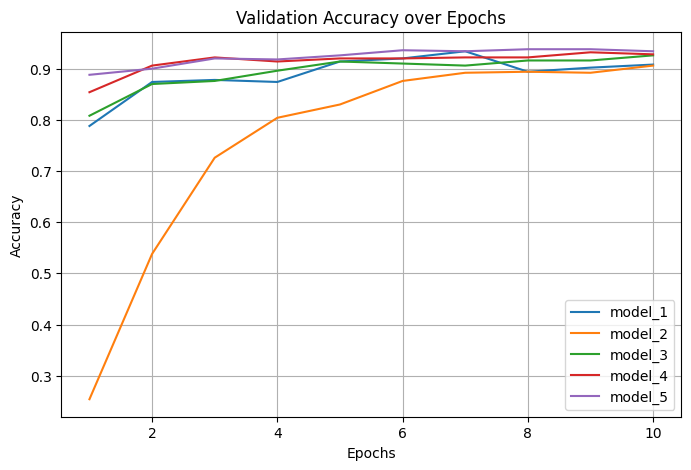

In [16]:
# Plot Validation Accuracy
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 11), history["valid_accuracy"], label=name)
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()